In [28]:
import pandas as pd

df = pd.read_csv('./Data/hotel_bookings.csv')\
    .rename(columns={'arrival_date_year':'year','arrival_date_month':'month','arrival_date_day_of_month':'day'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   year                            119390 non-null  int64  
 4   month                           119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   day                             119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [29]:
df['month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [30]:
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

In [31]:
df['month'] = df['month'].apply(monthToNum)
df['date']= pd.to_datetime(df[["year", "month", "day"]])
t_df = df[df['is_canceled']==0]
t_df = t_df.groupby(['date'])['hotel'].count().reset_index().rename(columns={'hotel':'sales'})
t_df = t_df.rename(columns={'sales':'y','date':'ds'}) 

In [32]:
import plotly.express as px

fig = px.line(t_df, x="ds", y="y", title='hotel demands')
fig.show()

In [33]:
t_df['ds'].min()

Timestamp('2015-07-01 00:00:00')

In [34]:
t_df['ds'].max()

Timestamp('2017-08-31 00:00:00')

In [35]:
train_df = t_df.loc[t_df['ds']<'2017-08-01']
test_df = t_df.loc[t_df['ds']>='2017-08-01']

In [36]:
fig = px.line(train_df, x="ds", y="y", title='hotel reservations')
fig.show()

In [37]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt


model = Prophet(daily_seasonality=False)
model.fit(train_df)

forecast = model.make_future_dataframe(periods=31)
pred = model.predict(forecast)



15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:00 - cmdstanpy - INFO - Chain [1] done processing


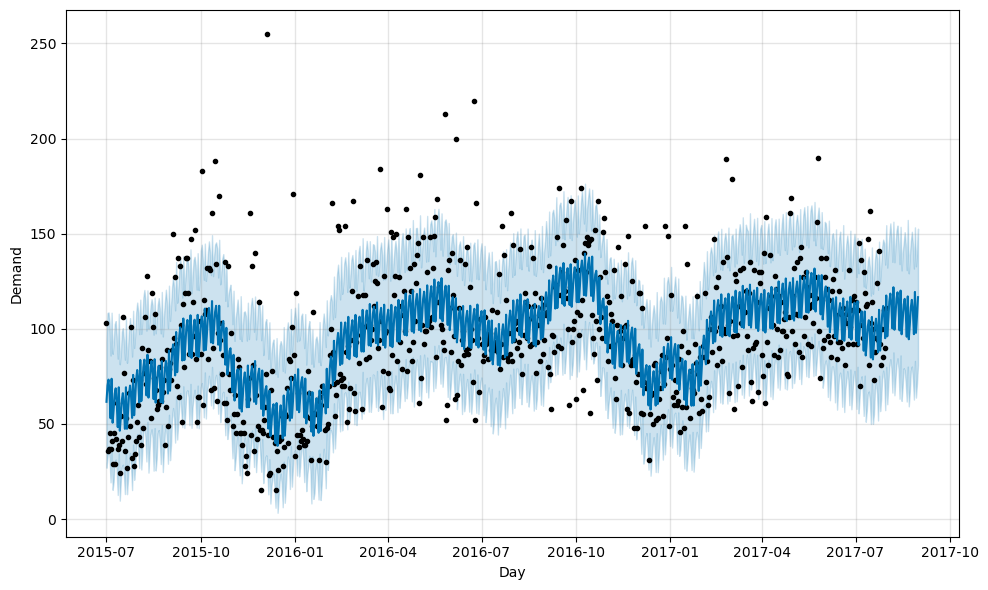

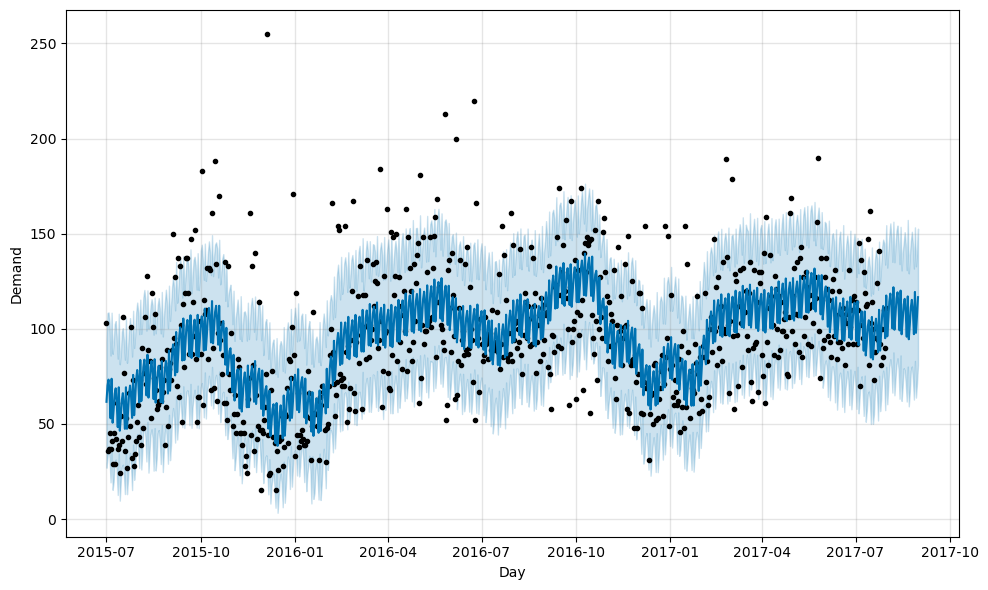

In [38]:
model.plot(pred, xlabel = 'Day', ylabel = 'Demand')

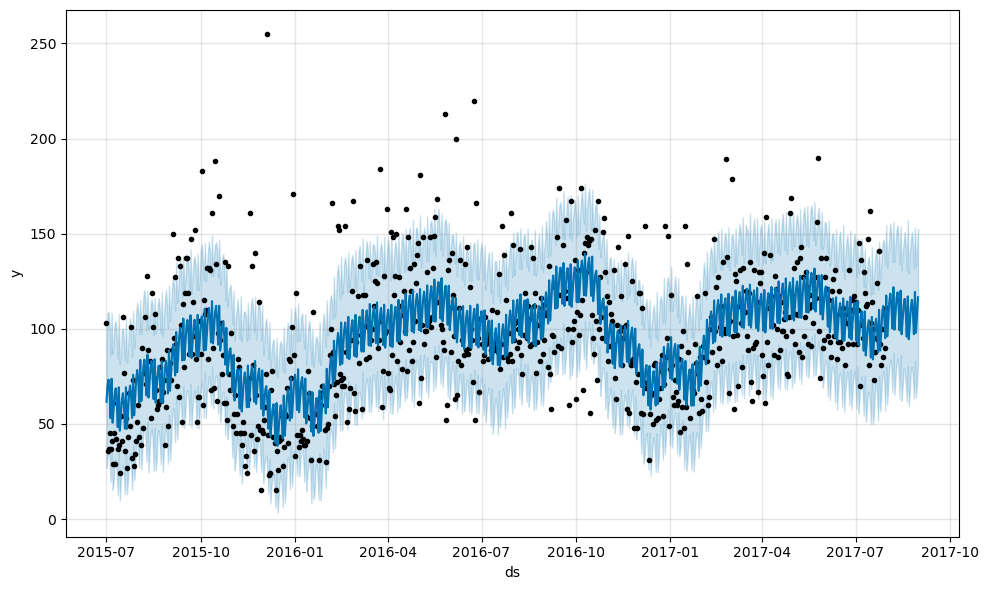

In [39]:
prophet_plot = model.plot(pred)

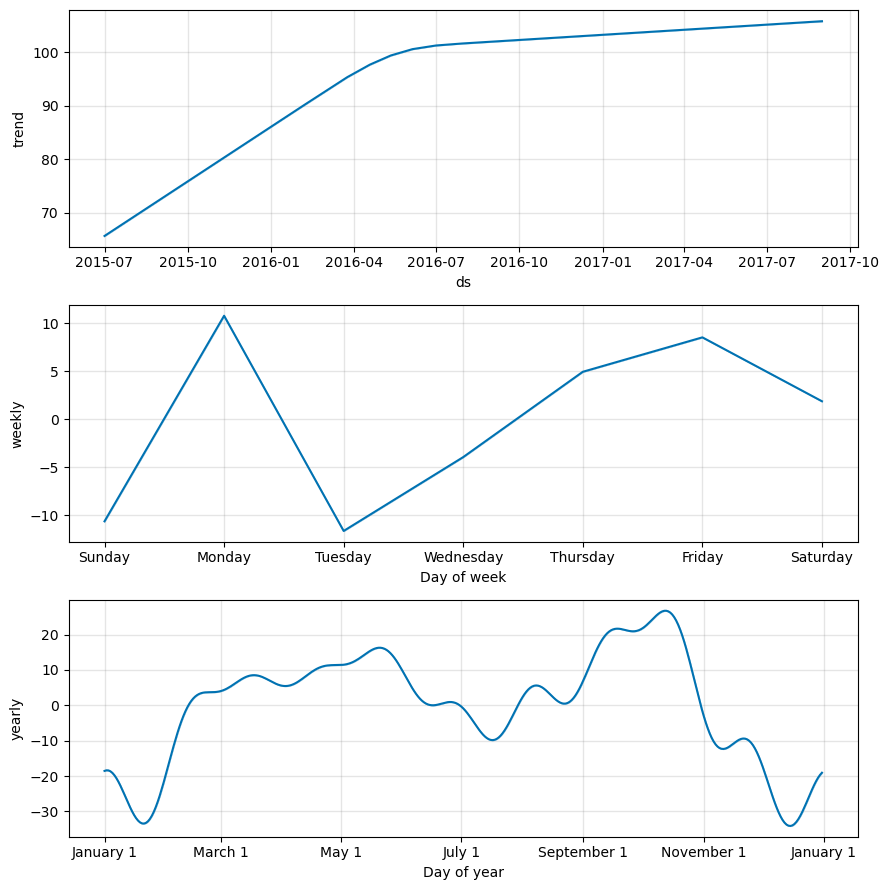

In [40]:
prophet_plot2 = model.plot_components(pred)

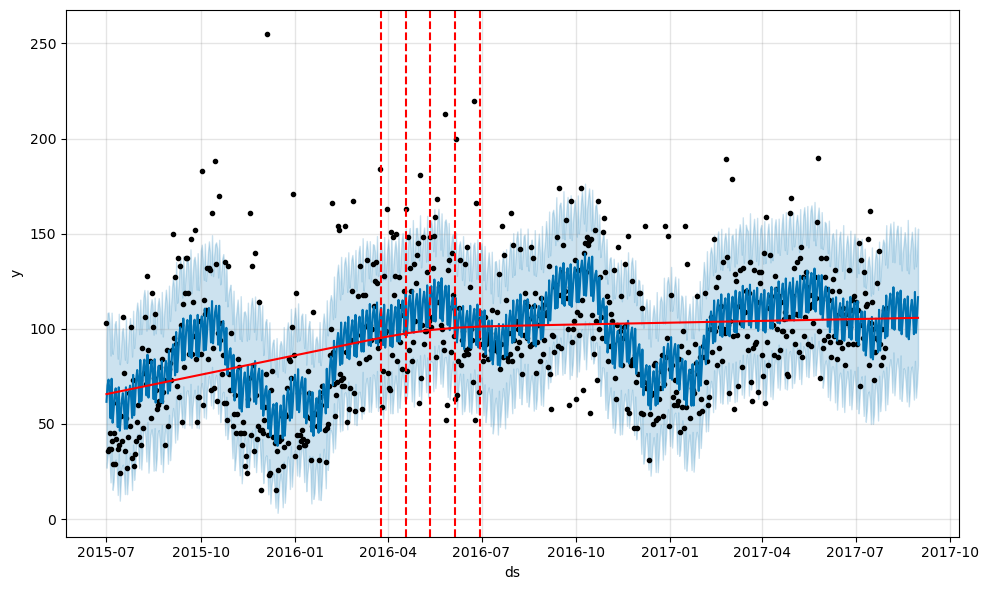

In [41]:
from prophet.plot import add_changepoints_to_plot

prophet_plot = model.plot(pred)
changepts = add_changepoints_to_plot(prophet_plot.gca(),model, pred)

In [42]:
print(model.changepoints)

24    2015-07-25
49    2015-08-19
73    2015-09-12
97    2015-10-06
122   2015-10-31
146   2015-11-24
170   2015-12-18
195   2016-01-12
219   2016-02-05
243   2016-02-29
268   2016-03-25
292   2016-04-18
316   2016-05-12
340   2016-06-05
365   2016-06-30
389   2016-07-24
413   2016-08-17
438   2016-09-11
462   2016-10-05
486   2016-10-29
511   2016-11-23
535   2016-12-17
559   2017-01-10
584   2017-02-04
608   2017-02-28
Name: ds, dtype: datetime64[ns]


In [43]:
"""
holidays = pd.DataFrame({"ds": [], "holiday": []})
prophet_holiday = Prophet(holidays=holidays)

prophet_holiday.add_country_holidays(country_name='US')
prophet_holiday.fit(t_df)
prophet_holiday.train_holiday_names
prophet_future = prophet_holiday.make_future_dataframe(periods=30)
prophet_forecast = prophet_holiday.predict(prophet_future)
prophet_plot_holiday = prophet_holiday.plot_components(prophet_forecast)
"""

'\nholidays = pd.DataFrame({"ds": [], "holiday": []})\nprophet_holiday = Prophet(holidays=holidays)\n\nprophet_holiday.add_country_holidays(country_name=\'US\')\nprophet_holiday.fit(t_df)\nprophet_holiday.train_holiday_names\nprophet_future = prophet_holiday.make_future_dataframe(periods=30)\nprophet_forecast = prophet_holiday.predict(prophet_future)\nprophet_plot_holiday = prophet_holiday.plot_components(prophet_forecast)\n'

In [47]:
forecast_df = test_df.merge(pred,left_on='ds', right_on='ds', how='inner').rename(columns={'yhat':'Phrophet_Forecast'})

from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(forecast_df[['Phrophet_Forecast']], forecast_df[['y']])))


Time Series: 16


<Axes: xlabel='ds'>

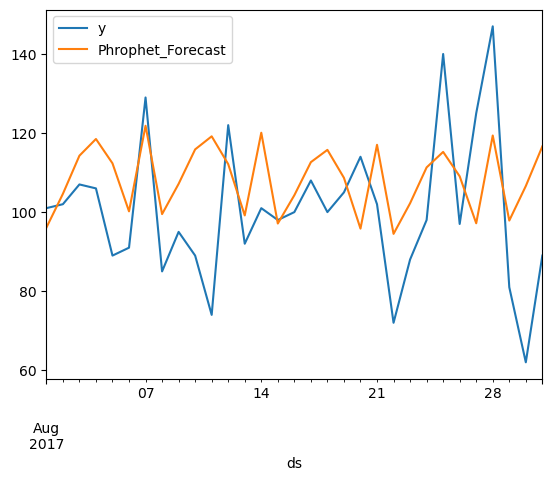

In [48]:
test_output_viz = forecast_df[['ds','y','Phrophet_Forecast']]
test_output_viz= test_output_viz.set_index('ds')

test_output_viz.plot.line()

ARIMA

In [49]:
train_df_arima = train_df.copy()
train_df_arima = train_df_arima.set_index('ds')

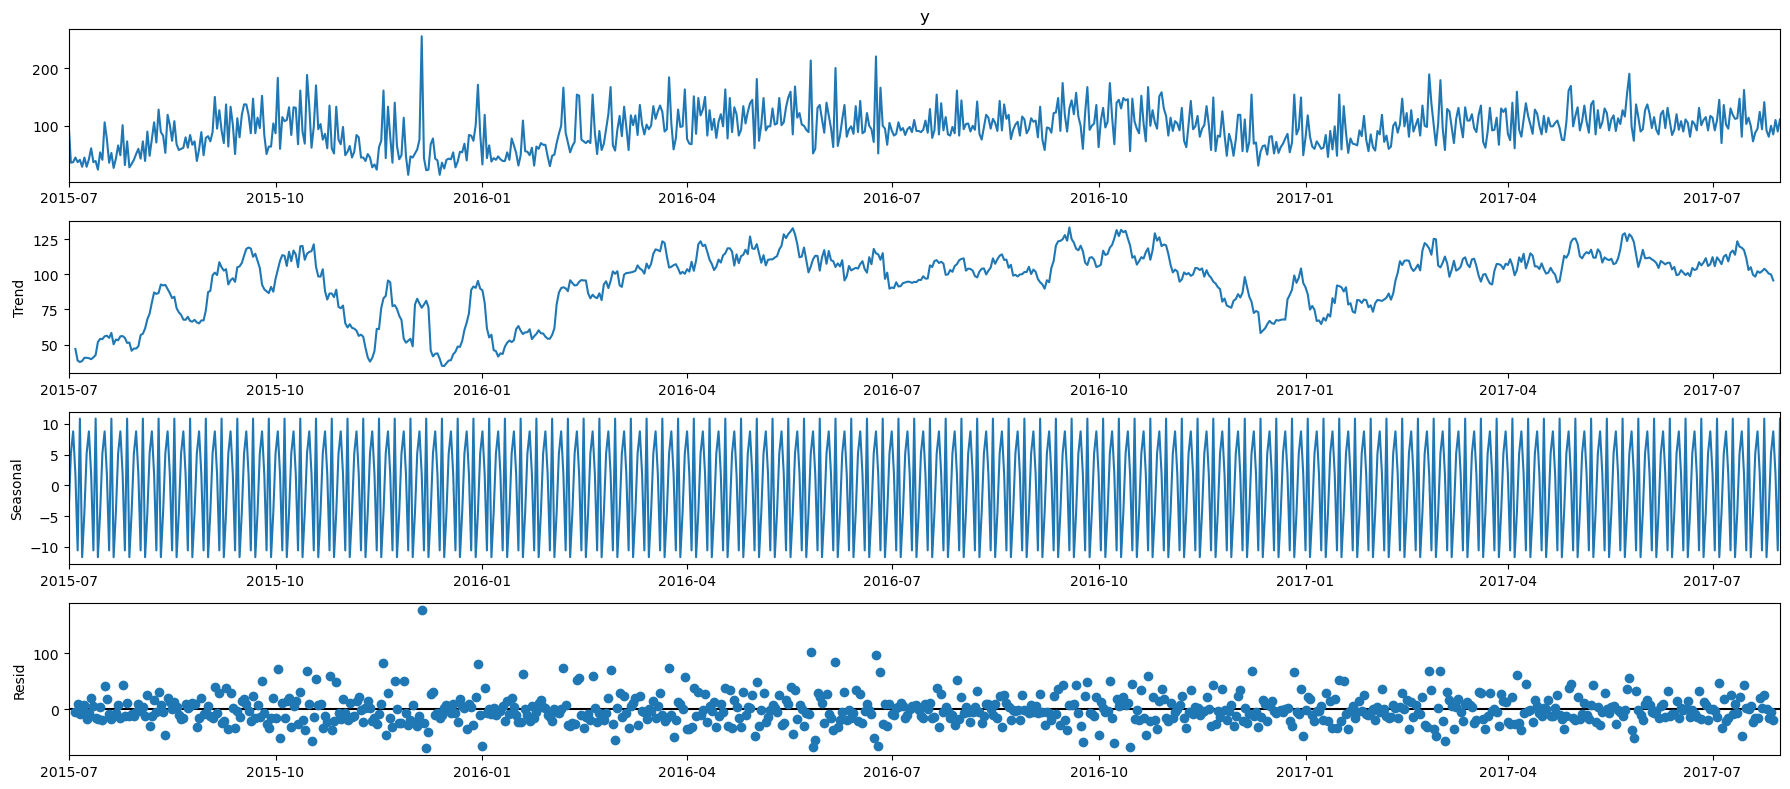

In [50]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(train_df_arima['y'], model='additive')
fig = decomposition.plot()
plt.show()

In [51]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(train_df_arima['y'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.0995372124979954
p-value: 0.026587455792373267


/Users/ycy/opt/anaconda3/envs/python3.9project/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



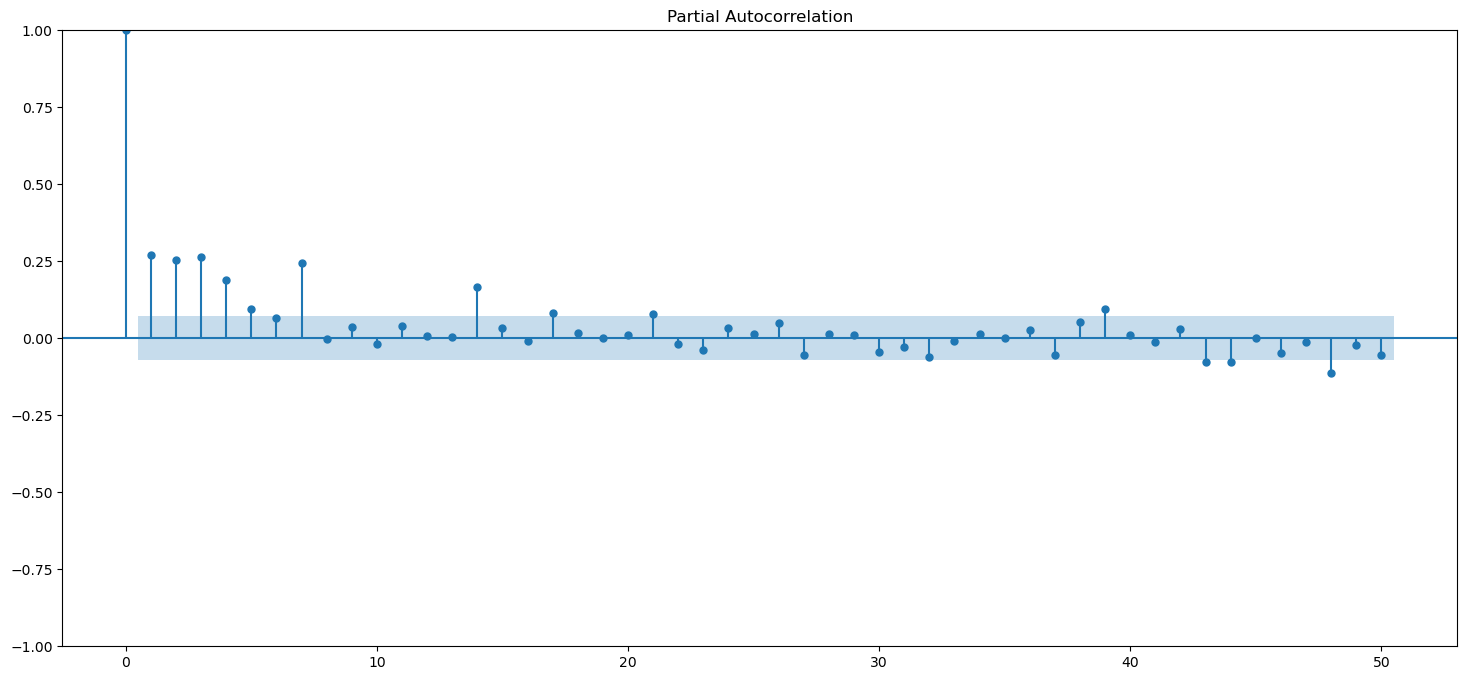

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(train_df_arima['y'], lags=50)

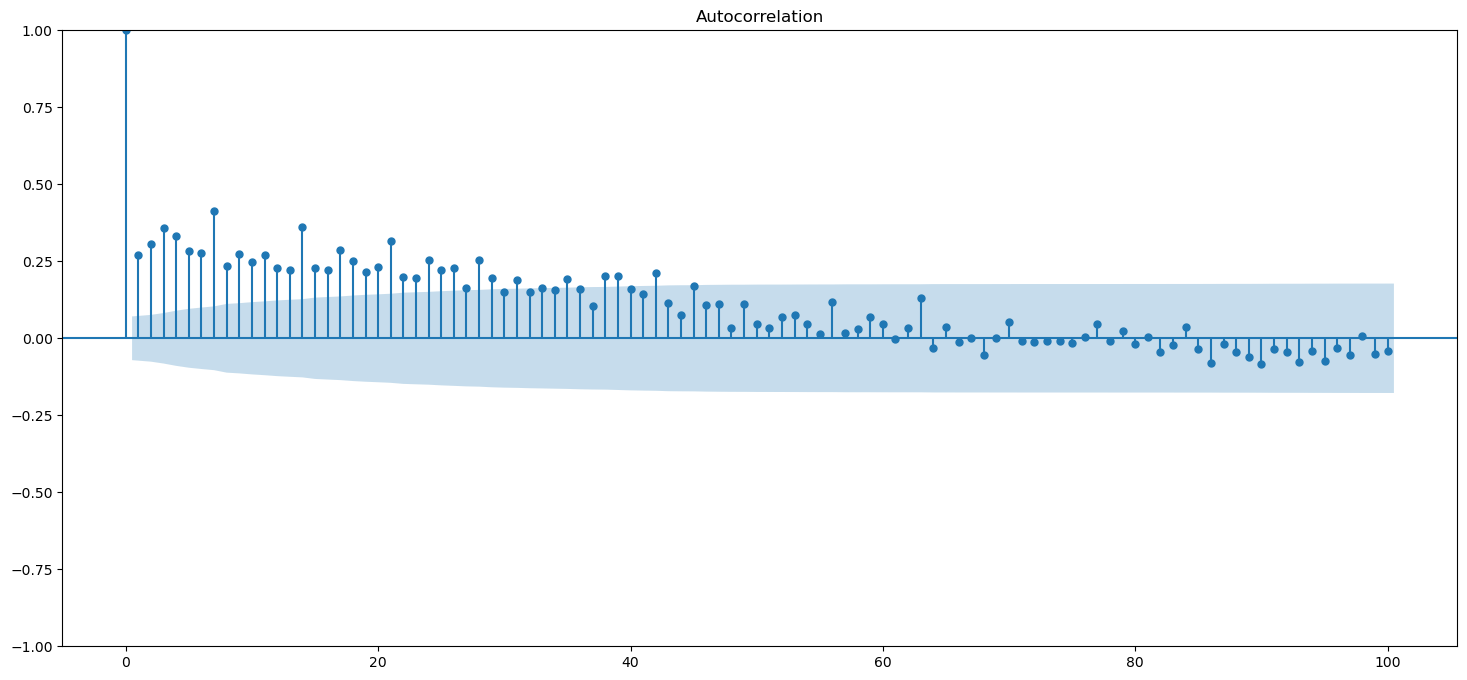

In [53]:
acf = plot_acf(train_df_arima['y'], lags=100)

In [54]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train_df_arima['y'],trace=True, error_action='ignore', suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7349.284, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7861.833, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7616.727, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7354.462, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7859.834, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7351.565, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7351.283, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7351.283, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7350.920, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7349.535, Time=0.76 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7351.843, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7330.331, Time=1.29 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7331.017, Time=1.69 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  762
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -3649.167
Date:                Sun, 07 May 2023   AIC                           7318.335
Time:                        15:27:57   BIC                           7364.681
Sample:                    07-01-2015   HQIC                          7336.181
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1625      0.051    -42.401      0.000      -2.262      -2.063
ar.L2         -2.6771      0.073    -36.544      0.000      -2.821      -2.533
ar.L3         -2.1125      0.074    -28.711      0.000      -2.257      -1.968
ar.L4         -0.9105      0.051    -17.883      0.000      -1.010      -0.811
ma.L1          1.2046      0.065     18.523      0.000       1.077       1.332
ma.L2          0.6881      0.058     11.957      0.000       0.575       0.801
ma.L3         -0.2995      0.047     -6.380      0.000      -0.392      -0.208
ma.L4         -0.9347      0.050    -18.847      0.000      -1.032      -0.838
ma.L5         -0.7399      0.063    -11.795      0.000      -0.863      -0.617
sigma2       868.6285     29.829     29.120      0.000     810.165     927.092
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               501.70
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
import statsmodels.api as sm
mod = sm.tsa.arima.ARIMA(train_df_arima['y'],order=(4, 1, 5))

results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  762
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -3649.167
Date:                Sun, 07 May 2023   AIC                           7318.335
Time:                        15:27:58   BIC                           7364.681
Sample:                    07-01-2015   HQIC                          7336.181
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1625      0.051    -42.401      0.000      -2.262      -2.063
ar.L2         -2.6771      0.073    -36.544      0.000      -2.821      -2.533
ar.L3         -2.1125      0.074    -28.711      0.0

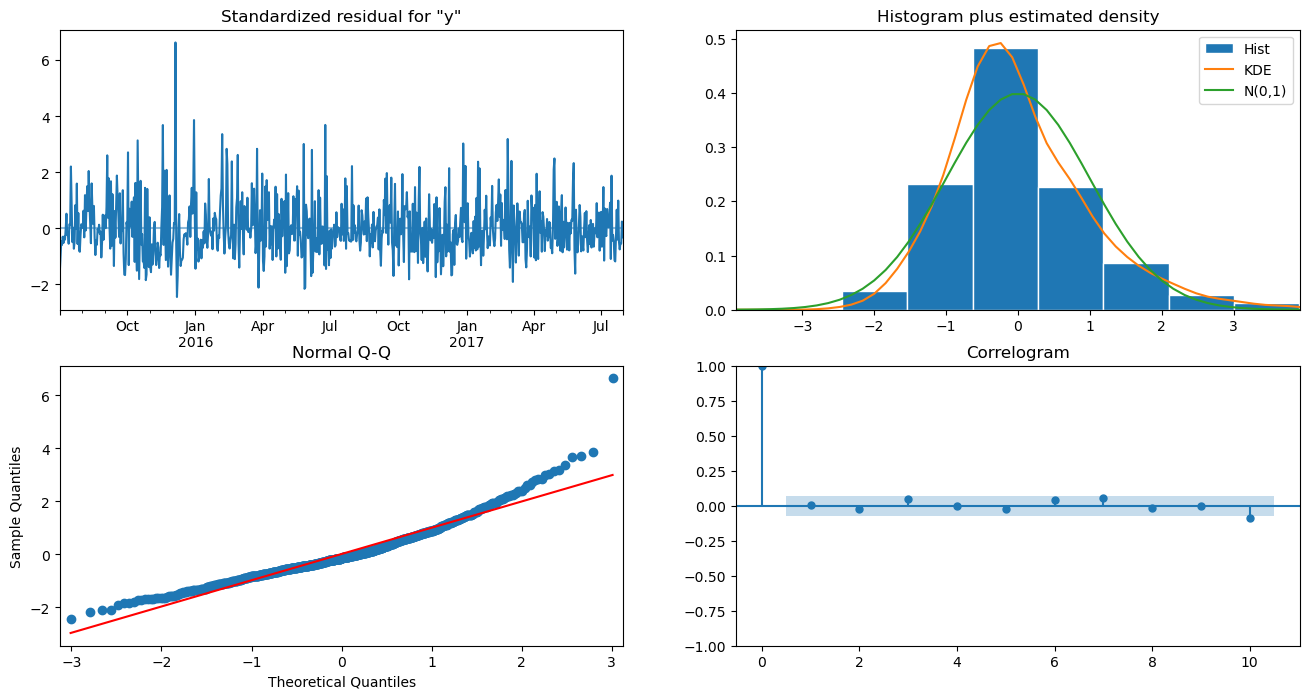

In [56]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [57]:
train_df_arima.index.max()

Timestamp('2017-07-31 00:00:00')

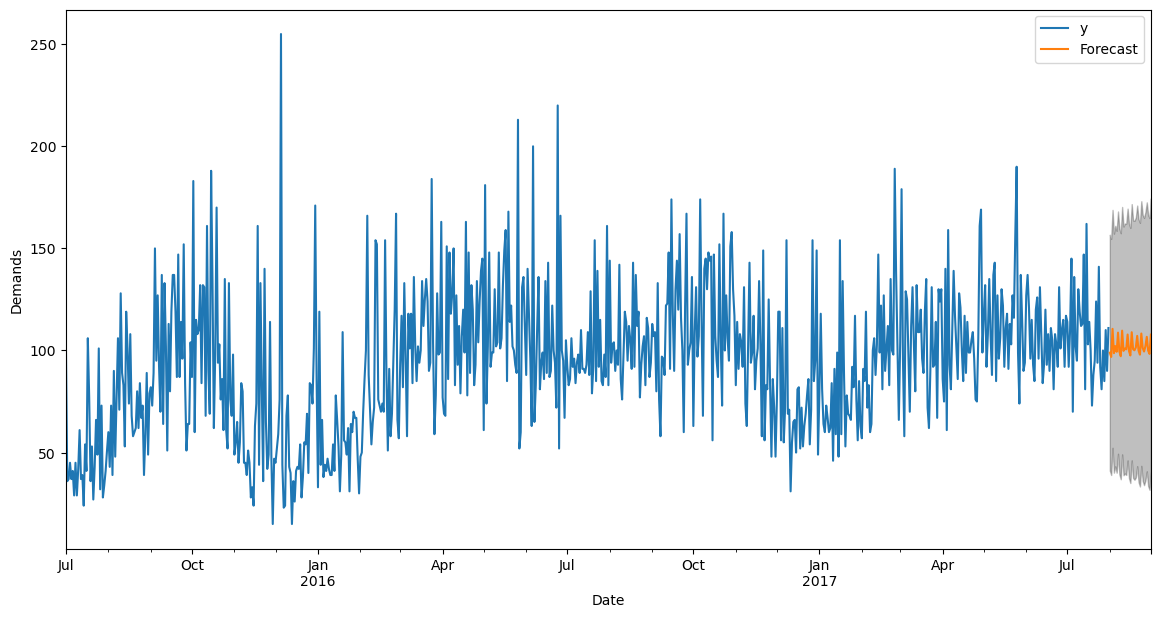

In [58]:
pred_uc = results.get_forecast(steps=31)
pred_ci = pred_uc.conf_int()
ax = train_df_arima.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Demands')
plt.legend()
plt.show()

<Axes: xlabel='ds'>

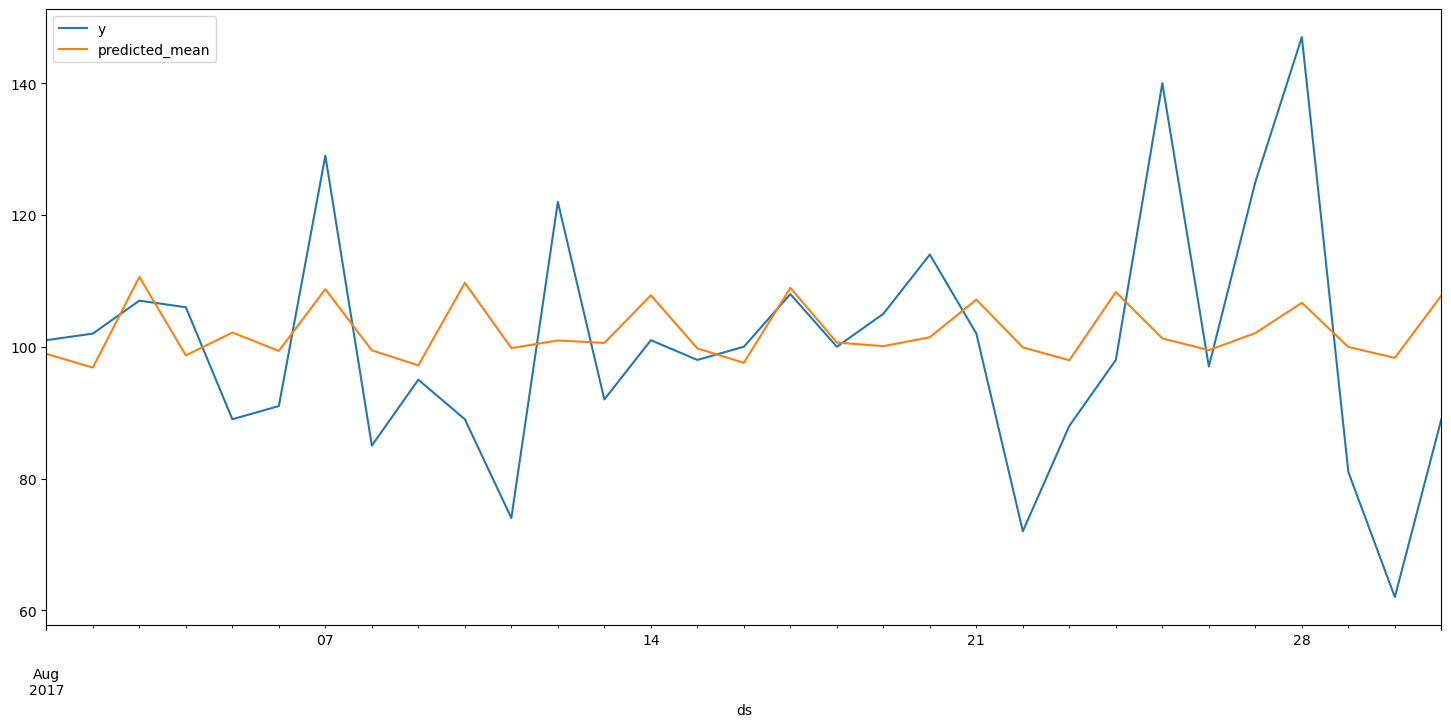

In [59]:
y= pd.DataFrame(results.forecast(steps=31)).reset_index()
test_output = test_df.merge(y,left_on='ds', right_on='index', how='inner').reset_index()
test_output_viz = test_output[['ds','y','predicted_mean']]
test_output_viz= test_output_viz.set_index('ds')

test_output_viz.plot.line()

In [60]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(test_output[['predicted_mean']], test_output[['y']])))

Time Series: 13


# LSTM

In [61]:
train_df_lstm = train_df.set_index('ds')

In [62]:
train_df_lstm

,y
ds,
2015-07-01,103
2015-07-02,36
2015-07-03,37
2015-07-04,45
2015-07-05,37
...,...
2017-07-27,100
2017-07-28,85
2017-07-29,110


In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df_lstm)
scaled_train = scaler.transform(train_df_lstm)

In [64]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 31
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

2023-05-07 15:28:03.738270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit(generator,epochs=10,verbose=2,callbacks=[earlyStop])

Epoch 1/10


2023-05-07 15:28:07.850347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


731/731 - 6s - loss: 0.1075 - 6s/epoch - 9ms/step
Epoch 2/10
731/731 - 4s - loss: 0.1000 - 4s/epoch - 6ms/step
Epoch 3/10
731/731 - 4s - loss: 0.1007 - 4s/epoch - 6ms/step
Epoch 4/10
731/731 - 4s - loss: 0.0991 - 4s/epoch - 6ms/step
Epoch 5/10
731/731 - 4s - loss: 0.0986 - 4s/epoch - 6ms/step
Epoch 6/10
731/731 - 4s - loss: 0.0982 - 4s/epoch - 6ms/step
Epoch 7/10
731/731 - 4s - loss: 0.0980 - 4s/epoch - 6ms/step
Epoch 8/10
731/731 - 4s - loss: 0.0967 - 4s/epoch - 6ms/step
Epoch 9/10
731/731 - 4s - loss: 0.0969 - 4s/epoch - 6ms/step
Epoch 10/10
731/731 - 4s - loss: 0.0955 - 4s/epoch - 6ms/step


In [68]:
import numpy as np
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

1/1 [==============================] - 0s 18ms/step


<Axes: xlabel='ds'>

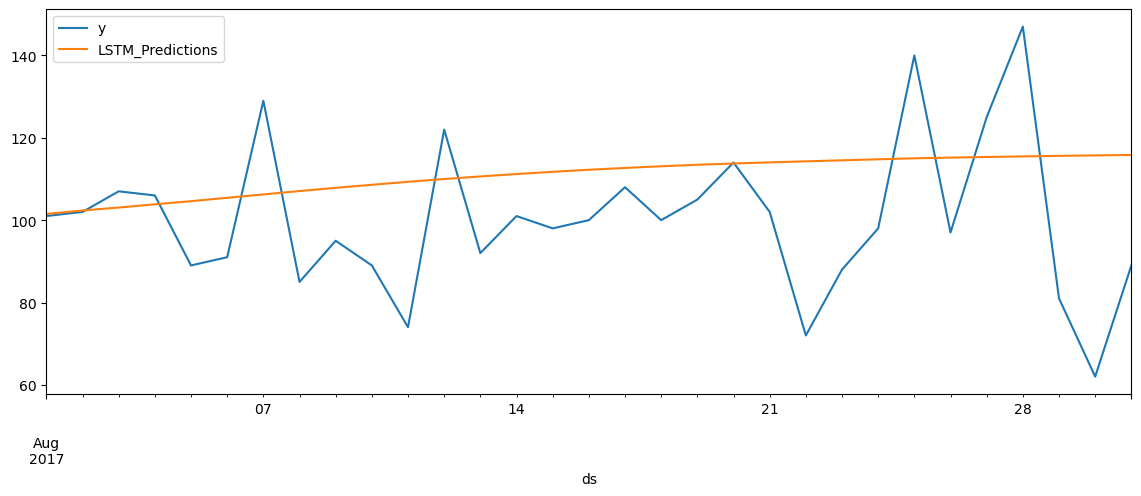

In [69]:
true_predictions = scaler.inverse_transform(test_predictions)
     
test_df['LSTM_Predictions'] = true_predictions
test_df = test_df.set_index('ds')
test_df.plot(figsize=(14,5))

In [70]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(test_df[['LSTM_Predictions']], test_df[['y']])))

Time Series: 17


# Pickup method

In [71]:
df['lead_time2'] = np.where(df["lead_time"] >365,365, df["lead_time"])

In [72]:
booking_matrix = df.loc[df['date']<'2017-08-01'].groupby(['date','lead_time2'])['hotel'].count().reset_index()
booking_matrix = booking_matrix.sort_values(['date', 'lead_time2'], ascending=[True, False])
booking_matrix['Cumsum'] = booking_matrix.groupby(['date'])['hotel'].transform(pd.Series.cumsum)
date_index = df.groupby("date")['hotel'].count().reset_index()
date_index['max'] = 365
date_index['min'] = 0
df1 = date_index.loc[date_index.index.repeat(date_index['max'].sub(date_index['min']) + 1)]
        
df1['value'] = df1['min'].add(df1.groupby(level=0).cumcount())
df1 = df1.drop(columns=['hotel','max','min'])
df1 = df1.sort_values(['date', 'value'], ascending=[True, False])
final_df =df1.merge(booking_matrix, left_on=['date','value'], right_on=['date','lead_time2'], how='left')
final_df['Cumsum2']= final_df.groupby('date')['Cumsum'].ffill()
final_df['Cumsum2']= final_df['Cumsum2'].fillna(0)

In [73]:
total =  df.groupby("date")['hotel'].count().reset_index()

In [74]:
roh = final_df[['date','value','Cumsum2']].merge(total, left_on=['date'], right_on=['date'], how='inner')
roh['aroh'] = roh['hotel'] - roh['Cumsum2']
lookup = roh.loc[roh['date']<'2017-08-01'].groupby('value')['aroh'].mean().round().reset_index()

In [75]:
from datetime import timedelta

In [82]:
booking_matrix = df.loc[df['date']>='2017-08-01'].groupby(['date','lead_time2'])['hotel'].count().reset_index()

booking_matrix = booking_matrix.sort_values(['date', 'lead_time2'], ascending=[True, False])
booking_matrix['Cumsum'] = booking_matrix.groupby(['date'])['hotel'].transform(pd.Series.cumsum)



In [84]:
booking_matrix['bookdate'] = booking_matrix['date']  - pd.to_timedelta(booking_matrix['lead_time2'], unit='D')

In [93]:
test =booking_matrix.loc[booking_matrix['bookdate']<'2017-08-01']

In [94]:
min= test.groupby('date')['lead_time2'].min().reset_index()

In [97]:
pickup = test.merge(min, left_on=['date','lead_time2'], right_on=['date','lead_time2'], how='inner').merge(lookup, left_on=['lead_time2'], right_on=['value'], how='inner')

In [99]:
pickup['pred'] = pickup['Cumsum'] + pickup['aroh']

In [102]:
pcikup_forecast = pickup[['date','pred']].merge(total, left_on='date', right_on='date')

In [103]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(pcikup_forecast[['pred']], pcikup_forecast[['hotel']])))

Time Series: 12


<Axes: xlabel='date'>

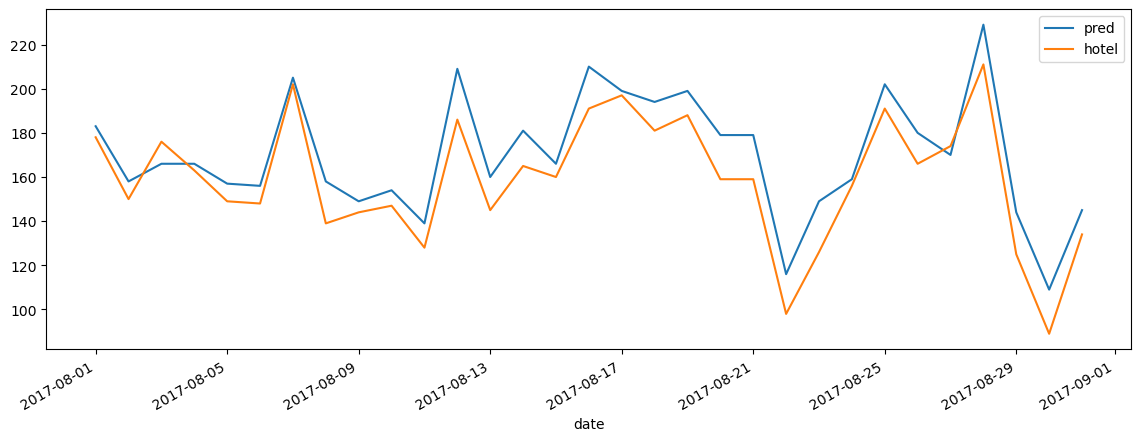

In [104]:
pcikup_forecast = pcikup_forecast.set_index('date')
pcikup_forecast.plot(figsize=(14,5))